In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Importing Libraries  📚

In [2]:
import os,shutil
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import zipfile
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import sklearn

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import glob
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img


from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.express as px
from plotly.subplots import make_subplots
print("Tensorflow Version: {}".format(tf.__version__))

Tensorflow Version: 2.7.0


In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

# 2.DATA IMPORT/ TRAIN, VAL & TEST DIRECTORY

In [4]:
path = "/content/drive/MyDrive/ProjectISE535"
os.chdir(path)
print(os.getcwd())

/content/drive/MyDrive/ProjectISE535


In [5]:

# import kaggle

# from kaggle.api.kaggle_api_extended import KaggleApi
# api = KaggleApi()
# api.authenticate()

# Kaggle API to download the dataset in local drive
#! kaggle competitions download -c plant-pathology-2020-fgvc7

root = os.getcwd()

zipFile = 'plant-pathology-2020-fgvc7.zip'
root = os.getcwd()
filePath = os.path.join(root,zipFile)

print("[INFO] Extracting downloaded zip dataset...... \n")
if os.path.exists(os.path.join(root,'images')) == False:
    with zipfile.ZipFile(filePath, 'r') as file:
        file.extractall()      
print("[INFO] Zip extract completed...... \n")


print("[INFO] Generating train dataframe...... \n")

trainDf = pd.read_csv(os.path.join(root, "train.csv"))
print("[INFO]  Shape of the train dataset: {}".format(trainDf.shape))

  
# FUCTION TO GET DISEASE CLASS NAME
def get_class(row):
    return(row.index[row.apply(lambda x: x==1)][0])

# prepare a ClassName column
trainDf['DiseaseClass'] = trainDf.apply(lambda row:get_class(row), axis=1)

trainDf.tail(8)

[INFO] Extracting downloaded zip dataset...... 

[INFO] Zip extract completed...... 

[INFO] Generating train dataframe...... 

[INFO]  Shape of the train dataset: (1821, 5)


,image_id,healthy,multiple_diseases,rust,scab,DiseaseClass
1813,Train_1813,0,0,1,0,rust
1814,Train_1814,1,0,0,0,healthy
1815,Train_1815,0,1,0,0,multiple_diseases
1816,Train_1816,0,0,0,1,scab
1817,Train_1817,1,0,0,0,healthy
1818,Train_1818,1,0,0,0,healthy
1819,Train_1819,0,0,1,0,rust
1820,Train_1820,0,0,0,1,scab


### 2.a Validation Directory

In [6]:
# split train dataset into train and validation (80-20 ratio)
from sklearn.model_selection import train_test_split
y = trainDf["DiseaseClass"]
df_train, df_val = train_test_split(trainDf, test_size=0.20, random_state=42, stratify=y)

print("[INFO] Shape of train dataset is: {}\n".format(df_train.shape))
print("[INFO] Shape of validation dataset is: {}\n".format(df_val.shape))

[INFO] Shape of train dataset is: (1456, 6)

[INFO] Shape of validation dataset is: (365, 6)



In [7]:
trainDir = os.path.join(root, 'train') # train directory
valDir = os.path.join(root, "val")     # validation directory
testDir = os.path.join(root, 'test')   #test directory



print("[INFO] Creating separate dirs for disease class in train directory ! \n")
if os.path.exists(trainDir) == False:  # if directory is absent craete one
    os.mkdir('train')
    trainDir = os.path.join(root, 'train') # train directory
    os.mkdir(os.path.join(trainDir, "healthy"))
    os.mkdir(os.path.join(trainDir, "rust"))
    os.mkdir(os.path.join(trainDir, "scab"))
    os.mkdir(os.path.join(trainDir, "multiple_diseases"))
    trainImage = list(df_train["image_id"])
#     for filename in os.listdir(os.path.join(root,"images")):
#         tail = os.path.split(filename)[-1]
#         if tail.split("_")[0]== "Train":
#             trainImage.append(filename)
            
    for file in tqdm(trainImage):
        file = file + '.jpg'
        index = trainDf.loc[trainDf["image_id"] == file.split(".")[0], "DiseaseClass"].index[0]
        label = trainDf.loc[trainDf["image_id"] == file.split(".")[0], "DiseaseClass"][index]
        src = os.path.join(root, 'images',file)
        dst = os.path.join(trainDir, label, file )
        shutil.copy2(src, dst)
        
print("[INFO] Creating separate dirs for disease class in validation directory ! \n") 
if os.path.exists(valDir) == False:  # if directory is absent craete one
    os.mkdir('val')
    valDir = os.path.join(root, "val") # validation directory
    os.mkdir(os.path.join(valDir, "healthy"))
    os.mkdir(os.path.join(valDir, "rust"))
    os.mkdir(os.path.join(valDir, "scab"))
    os.mkdir(os.path.join(valDir, "multiple_diseases"))
    
    valImage = list(df_val["image_id"])
    for file in valImage:
        file = file + '.jpg'
        index = trainDf.loc[trainDf["image_id"] == file.split(".")[0], "DiseaseClass"].index[0]
        label = trainDf.loc[trainDf["image_id"] == file.split(".")[0], "DiseaseClass"][index]
        src = os.path.join(root, 'images',file)
        dst = os.path.join(valDir, label, file )
        shutil.copy2(src, dst)
        

print("[INFO] Creating separate test directory ! \n")
if os.path.exists(testDir) == False:  # if directory is absent craete one
    os.mkdir('test')
    testDir = os.path.join(root, 'test')
    testImage = []
    for filename in os.listdir(os.path.join(root,"images")):
        tail = os.path.split(filename)[-1]
        if tail.split("_")[0]== "Test":
            testImage.append(filename)
    for file in testImage:
        src = os.path.join(os.path.join(root, 'images'),file)
        dst = os.path.join(root, 'test')
        shutil.copy2(src, dst)


print("[INFO] Total test images in test directory: {}".format(len(os.listdir(testDir))))


[INFO] Creating separate dirs for disease class in train directory ! 

[INFO] Creating separate dirs for disease class in validation directory ! 

[INFO] Creating separate test directory ! 

[INFO] Total test images in test directory: 1821


# 3.TARGET CLASS

In [8]:
import plotly.express as px

df = px.data.tips()
fig = px.parallel_categories(trainDf, dimensions=[ 'healthy', 'rust', 'multiple_diseases', 'scab'],
                             color = "healthy",
                color_continuous_scale=px.colors.sequential.Inferno,
                labels={'rust':'RUST LEAF', 'healthy':'HEALTHY LEAF', 'multiple_diseases':'MULTIPLE DISEASES', 'scab':'SCAB'},
                            title="PARALLEL CATEGORICAL PLOT OF DISEASE CLASS ")
fig.show(renderer="colab")

In [9]:
className = ["healthy", "multiple_diseases", "rust", "scab"]
classCount = []
for name in className:
    result = sum(trainDf[trainDf[name]==1].value_counts())
    classCount.append(result)
    
data = {"ClassName":className, "Count":classCount}  
countDf = pd.DataFrame(data=data)

fig = px.bar(countDf, x='ClassName',y='Count', title="Distribution of Image Disease Class in Train Dataset", width=800, height=400)

fig.update_traces(marker_color='rgb(150,100,225)', marker_line_color='rgb(8,48,107)', marker_line_width=1.5, opacity=0.4)

fig.show(renderer="colab")

### 3.a Train Dataset Visualization

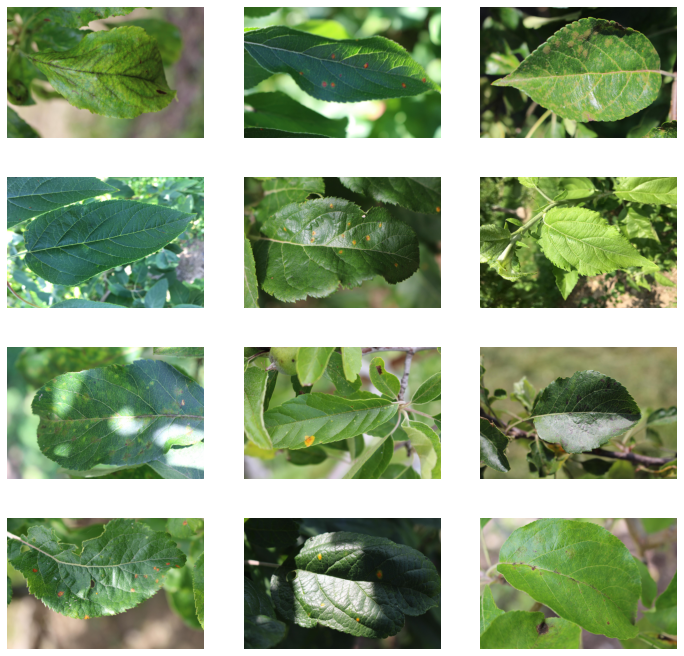

In [ ]:
images = os.listdir(os.path.join(root,"images"))[:12]
className = []    
plt.figure(figsize = (12,12))
for i,img in enumerate(images):
    imgPath = os.path.join(root,"images",img)
    plt.subplot(4,3,i+1)
    plt.axis('off')
    #plt.title(title, size=9, color='black')
    img = cv2.imread(imgPath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img/255)
    #fig = px.imshow(img)
    #fig.show()
plt.show()

### 3.b Visulaizing a single leaf

In [ ]:
image = os.listdir(os.path.join(root, "train", "rust"))[23]
index = trainDf.loc[trainDf["image_id"]==image.split(".")[0], "DiseaseClass"].index
title = trainDf.loc[trainDf["image_id"]==image.split(".")[0], "DiseaseClass"][index]
imgPath = os.path.join(root, "train", "rust", image)
img = cv2.imread(imgPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   #for cv2 conversion from BGR to RGB
fig = px.imshow(img/255)
fig.update_layout(title_text=str(title), title_x=0.5)
            
fig.show(renderer="colab")


### 3.c Visulaizing a "MULTIPLE DISEASE" leaf class

In [ ]:
file = os.listdir(os.path.join(root,"train","multiple_diseases"))[9]
imgPath = os.path.join(root, "train", "multiple_diseases", file)
img = cv2.imread(imgPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = img/255
fig = make_subplots(1,2)
fig.add_trace(go.Image(z=img), 1, 1)
for channel,color in enumerate(['red', 'green', 'blue']):
    fig.add_trace(go.Histogram(x=img[...,channel].ravel(), opacity = 0.5,
                              marker_color = color, name = '%s Channel'%color), 1, 2)
fig.update_layout( title = "LEAF WITH MULTIPLE DISEASE", title_x=0.5)
fig.show(renderer="colab")

### 3.d Visulaizing a "HEALTHY" leaf class

In [ ]:
file = os.listdir(os.path.join(root,"train","healthy"))[9]
imgPath = os.path.join(root, "train", "healthy", file)

img = cv2.imread(imgPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = make_subplots(1,2)
fig.add_trace(go.Image(z=img), 1, 1)
for channel,color in enumerate(['red', 'green', 'blue']):
    fig.add_trace(go.Histogram(x=img[...,channel].ravel(), opacity = 0.5,
                              marker_color = color, name = '%s Channel'%color), 1, 2)
fig.update_layout(height = 400, title = "HEALTHY LEAF", title_x=0.5)
fig.show(renderer="colab")

### 3.e Visulaizing a "RUST" leaf class

In [ ]:
file = os.listdir(os.path.join(root,"train","rust"))[9]
imgPath = os.path.join(root, "train", "rust", file)

img = cv2.imread(imgPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = make_subplots(1,2)
fig.add_trace(go.Image(z=img), 1, 1)
for channel,color in enumerate(['red', 'green', 'blue']):
    fig.add_trace(go.Histogram(x=img[...,channel].ravel(), opacity = 0.5,
                              marker_color = color, name = '%s Channel'%color), 1, 2)
fig.update_layout(height = 400, title = "RUST LEAF", title_x=0.5)
fig.show(renderer="colab")

### 3.f Visulaizing a "SCAB" leaf class

In [ ]:
file = os.listdir(os.path.join(root,"train","scab"))[9]
imgPath = os.path.join(root, "train", "scab", file)

img = cv2.imread(imgPath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig = make_subplots(1,2)
fig.add_trace(go.Image(z=img), 1, 1)
for channel,color in enumerate(['red', 'green', 'blue']):
    fig.add_trace(go.Histogram(x=img[...,channel].ravel(), opacity = 0.5,
                              marker_color = color, name = '%s Channel'%color), 1, 2)
fig.update_layout(height = 400, title = "SCAB LEAF", title_x=0.5)
fig.show(renderer="colab")

# 4.PRE-PROCESSING AND IMAGE AUGMENTATION

### 4.a Image Augmentation

In [10]:
# IMAGE DATA GENERATOR
if os.path.exists(os.path.join(root, "aug_dir"))==False:
    os.mkdir(os.path.join(root, "aug_dir"))
    aug_dir = os.path.join(root, "aug_dir")
    datagen = ImageDataGenerator(
                                rotation_range=45,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.1,
                                brightness_range=(0.5, 1.5),
                                horizontal_flip=True,
                                vertical_flip=True,
                                fill_mode="nearest")

    images = os.path.join(os.getcwd(), "train", "multiple_diseases")

    for fname in os.listdir(images):
        img = os.path.join(root, "train", "multiple_diseases",fname)
        img = load_img(img)
        img_arr = img_to_array(img)  #convert to array
        img_arr = tf.expand_dims(img_arr, axis=0)  # adding batch dimension 

        i = 0
        for batch in datagen.flow(img_arr,
                                 batch_size=1,
                                 save_to_dir=os.path.join(root, "aug_dir"),
                                 save_prefix='Augmented_image',
                                 save_format='jpg'
                                 ):
            i += 1
            if i>5:
                break
    #Visualizating 10 Augmented Image
    
    # aug_imgs = []
    # for img_path in glob.glob(aug_dir+'\\*jpg')[:15]:
    #     img = cv2.imread(img_path)
    #     aug_imgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.figure(figsize=(20,10))
    # columns = 5

    # for i, image in enumerate(aug_imgs):
    #     plt.subplot(len(aug_imgs) / columns + 1, columns, i + 1)
    #     plt.axis("off")
    #     plt.imshow(image)
    # plt.title("AUGMENTED MULTIPLE DISEASES CLASS IMAGE")
    # plt.show()

    # Move augmented image to train/multiple_diseases directory
    src_dir = os.path.join(root, "aug_dir")
    dst_dir = os.path.join(root, "train", "multiple_diseases")
    files = os.listdir(src_dir)
    for file in files:
        shutil.move(os.path.join(src_dir,file), dst_dir)
    #shutil.rmtree(os.path.join(root,"train", "aug_dir"))    
    print("[INFO] Augmented file moved to Multiple Diseases directory")


In [11]:
# ADDING AUG IMAGE TO DATAFRAME
AugImg = []

multipleD_dir = os.path.join(root,"train","multiple_diseases")
for fname in os.listdir(multipleD_dir):
  if fname.split("_")[0] == "Augmented":
    AugImg.append(fname.split(".")[0])
for i, _ in enumerate(AugImg[1:]):
  trainDf.loc[1+len(trainDf.index[1:])] = [AugImg[i], 0, 1, 0, 0, "multiple_diseases"]
trainDf.tail()

print("[INFO] Shape of the dataset is {}".format(trainDf.shape))

[INFO] Shape of the dataset is (2253, 6)


In [12]:
diseaseClass = ["healthy", "multiple_diseases", "rust", "scab"]
countDict = {}
for className in diseaseClass:
    path = os.path.join(root, "train", className)
    count = len(os.listdir(path))
    countDict[className] = count
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig = go.Figure(data=[go.Pie(labels=['healthy','multiple_diseases','rust','scab'],
                             values=[413,505,497,473], hole = 0.04, pull = [0,0.3,0,0])])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update(layout_title_text='Image Distribution in Train Dataset After Image Augmentation',
           layout_showlegend=False)
fig.show(renderer="colab")

In [13]:
trainDf["image_id"] = trainDf["image_id"].astype(str)+".jpg"
dataframeDict = {}
for base, dirs, files in os.walk(trainDir):
  for file in files:
    file_path=os.path.join(base,file)
    dataframeDict[file] = file_path
for base, dirs, files in os.walk(valDir):
  for file in files:
    file_path=os.path.join(base,file)
    dataframeDict[file] = file_path 


trainDf["file_path"] = trainDf["image_id"].apply(lambda x: dataframeDict[x])

trainDf.tail(-2)

,image_id,healthy,multiple_diseases,rust,scab,DiseaseClass,file_path
2,Train_2.jpg,1,0,0,0,healthy,/content/drive/MyDrive/ProjectISE535/train/hea...
3,Train_3.jpg,0,0,1,0,rust,/content/drive/MyDrive/ProjectISE535/val/rust/...
4,Train_4.jpg,1,0,0,0,healthy,/content/drive/MyDrive/ProjectISE535/val/healt...
5,Train_5.jpg,1,0,0,0,healthy,/content/drive/MyDrive/ProjectISE535/train/hea...
6,Train_6.jpg,0,1,0,0,multiple_diseases,/content/drive/MyDrive/ProjectISE535/val/multi...
...,...,...,...,...,...,...,...
2248,Augmented_image_0_529.jpg,0,1,0,0,multiple_diseases,/content/drive/MyDrive/ProjectISE535/train/mul...
2249,Augmented_image_0_5702.jpg,0,1,0,0,multiple_diseases,/content/drive/MyDrive/ProjectISE535/train/mul...
2250,Augmented_image_0_9970.jpg,0,1,0,0,multiple_diseases,/content/drive/MyDrive/ProjectISE535/train/mul...
2251,Augmented_image_0_1034.jpg,0,1,0,0,multiple_diseases,/content/drive/MyDrive/ProjectISE535/train/mul...


# 5.MODEL SELECTION

In [14]:
IMG_SIZE = (224, 224)
BATCH_SIZE  = 64
IMG_SHAPE = IMG_SIZE + (3,)
AUTO = tf.data.experimental.AUTOTUNE

def path(dirs):
    return os.path.join(root,"images", dirs)+ ".jpg"

def decode_image(fname, label = None, image_size = (224,224)):
    bits = tf.io.read_file(fname)
    img = tf.io.decode_jpeg(bits, channels=3)
    img = tf.cast(img, tf.float32)/255.0
    img = tf.image.resize(img, image_size)
    
    if label is None:
        return img
    else:
        return img, label


data_aug = tf.keras.Sequential([
                            tf.keras.layers.RandomFlip("horizontal"),
                            tf.keras.layers.RandomRotation(0.2),
                            tf.keras.layers.RandomTranslation(height_factor = (-0.2, 0.3), width_factor = (-0.2, 0.3))])

# Train & Validation image path
#train_paths = df_train["image_id"].apply(path).values

#print(train_paths)
# validation_paths = df_val["image_id"].apply(path).values

# # Train & Validation Label
# train_labels = np.float32(df_train.loc[:, "healthy":"scab"].values) 
# validation_labels = np.float32(df_val.loc[:, "healthy":"scab"].values) 



# train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(decode_image,num_parallel_calls=AUTO).repeat().shuffle(224).batch(BATCH_SIZE).prefetch(AUTO)
# validation_dataset = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels)).map(decode_image, num_parallel_calls=AUTO).batch(BATCH_SIZE)


### 5.a SEQUENTIAL MODEL

In [15]:
# FUNCTION TO PLOT ACCURACY AND LOSS CURVE

def plot_accuracy_loss_curve(history):

  '''
  A function to visualize train/ validation accuracy and loss curve
  
  '''
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  EPOCHS = len(acc)
  fig = make_subplots(rows=1, cols=2)

  # For Train
  fig.add_trace(go.Scatter(x = np.arange(1,EPOCHS+1), y = acc, marker=dict(color="dodgerblue"),
               name="Train Accuracy"), row=1, col=1)
  fig.add_trace(go.Scatter(x = np.arange(1,EPOCHS+1), y = val_acc, marker=dict(color="darkkhaki"),
               name="Validation Accuracy"), row=1, col=1)
  fig.update_xaxes(title_text = "EPOCHS",   row=1, col=1)
  fig.update_yaxes(title_text = "% ACCURACY", row=1, col=1)

  #For Loss
  fig.add_trace(go.Scatter(x = np.arange(1,EPOCHS+1), y = loss, marker=dict(color="darksalmon"),
               name="Train Loss"), row=1, col=2)
  fig.add_trace(go.Scatter(x = np.arange(1,EPOCHS+1), y = val_loss, marker=dict(color="darkseagreen"),
               name="Validation Loss"), row=1, col=2)
  fig.update_xaxes(title_text = "EPOCHS",  row=1, col=2)
  fig.update_yaxes(title_text = "% LOSS", row=1, col=2)

  fig.update_layout(title_text= "ACCURACY AND LOSS PLOT OF TRAIN/VALIDATION DATASET")

  fig.show(renderer="colab")


In [16]:

class Sequential_Model():
    @staticmethod
    def build(IMG_SHAPE, classes):
        inputShape = IMG_SHAPE

        model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64, (5,5), padding="valid", strides = (2,2), input_shape=inputShape), # check kernel
            tf.keras.layers.Activation("relu"),   
            tf.keras.layers.MaxPooling2D(),   
            tf.keras.layers.Conv2D(32, (5,5) ),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64),
            tf.keras.layers.Activation("relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(classes, activation = "softmax")
        ])

        return model
        
model = Sequential_Model.build(IMG_SHAPE=IMG_SHAPE, classes = 4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 64)      4864      
                                                                 
 activation (Activation)     (None, 110, 110, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 51, 32)        51232     
                                                                 
 activation_1 (Activation)   (None, 51, 51, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 51, 51, 32)       128       
 ormalization)                                        

In [17]:
# IMAGE DATA GENERATOR
train_idg = ImageDataGenerator(width_shift_range=0.,
                         height_shift_range=0.2,
                         rotation_range = 90,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255)
valid_idg = ImageDataGenerator(rescale = 1./255)


VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold_var = 1

save_dir = (os.path.join(root, "saved_model"))

# GENERATE SAVED MODEL NAME
def get_model_name(k):
  return 'model_'+str(k)+'.h5'

from sklearn.model_selection import StratifiedShuffleSplit
n_sample = trainDf.shape[0]

split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

for train_index, val_index in split.split(np.zeros(n_sample), trainDf["DiseaseClass"]):
  df_train = trainDf.loc[train_index]
  df_val = trainDf.loc[val_index]

  train_dataset = train_idg.flow_from_dataframe(dataframe=df_train,
                                         x_col = "file_path",
                                         y_col = "DiseaseClass",
                                         target_size = (224,224),
                                          color_mode = "rgb"
                                         )
  
  validation_dataset = valid_idg.flow_from_dataframe(dataframe=df_val,
                                         x_col = "file_path",
                                         y_col = "DiseaseClass",
                                         target_size = (224,224),
                                         color_mode="rgb"
                                         )
  
  # CREATE A NEW MODEL
  model = Sequential_Model.build(IMG_SHAPE=IMG_SHAPE, classes = 4)

  # COMPILE MODEL
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
                                                   loss = tf.keras.losses.CategoricalCrossentropy(),
                                                   metrics = ['accuracy'])
  # CREATING CHECKPOINT CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(save_dir,get_model_name(fold_var)),
                                                  monitor = "val_accuracy", verbose = 1,
                                                  save_best_only = True, mode = "max")
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 2)
  def scheduler(epoch, lr):
    if epoch < 5:
      return lr
    else:
      return lr*tf.math.exp(-0.1)
  
  learningRateSch = tf.keras.callbacks.LearningRateScheduler(scheduler)

  callback_list = [checkpoint, earlystop, learningRateSch]
  # FIT THE MODEL
  STEP_SIZE_TRAIN = train_dataset.n//BATCH_SIZE
  STEP_SIZE_VAL = validation_dataset.n//BATCH_SIZE
  history = model.fit(train_dataset,
                      epochs = 20,
                      steps_per_epoch = STEP_SIZE_TRAIN,
                      validation_steps = STEP_SIZE_VAL,
                      callbacks = callback_list,
                      validation_data = validation_dataset)
  plot_accuracy_loss_curve(history)

  tf.keras.backend.clear_session()

  fold_var += 1

Found 1802 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.
Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 5.9728 - accuracy: 0.2478
Epoch 00001: val_accuracy improved from -inf to 0.18750, saving model to /content/drive/MyDrive/ProjectISE535/saved_model/model_1.h5
28/28 [==============================] - 340s 12s/step - loss: 5.9728 - accuracy: 0.2478 - val_loss: 69.3410 - val_accuracy: 0.1875 - lr: 0.0100
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 2.2530 - accuracy: 0.2757
Epoch 00002: val_accuracy improved from 0.18750 to 0.22768, saving model to /content/drive/MyDrive/ProjectISE535/saved_model/model_1.h5
28/28 [==============================] - 176s 6s/step - loss: 2.2530 - accuracy: 0.2757 - val_loss: 859.2789 - val_accuracy: 0.2277 - lr: 0.0100
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 1.4930 - accuracy: 0.2986
Epoch 00003: val_accuracy improved fro

Found 1802 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.
Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 8.5994 - accuracy: 0.2757
Epoch 00001: val_accuracy improved from -inf to 0.29464, saving model to /content/drive/MyDrive/ProjectISE535/saved_model/model_2.h5
28/28 [==============================] - 84s 3s/step - loss: 8.5994 - accuracy: 0.2757 - val_loss: 8.3956 - val_accuracy: 0.2946 - lr: 0.0100
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 1.3848 - accuracy: 0.2712
Epoch 00002: val_accuracy improved from 0.29464 to 0.30804, saving model to /content/drive/MyDrive/ProjectISE535/saved_model/model_2.h5
28/28 [==============================] - 67s 2s/step - loss: 1.3848 - accuracy: 0.2712 - val_loss: 1.5023 - val_accuracy: 0.3080 - lr: 0.0100
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 1.3888 - accuracy: 0.2471
Epoch 00003: val_accuracy improved from 0.30

### 5.b MobileNetV2

In [21]:
from tensorflow.keras.applications import MobileNetV2

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [23]:
# IMAGE DATA GENERATOR
train_idg = ImageDataGenerator(width_shift_range=0.,
                         height_shift_range=0.2,
                         rotation_range = 90,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255)
valid_idg = ImageDataGenerator(rescale = 1./255)


VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold_var = 1

save_dir = (os.path.join(root, "saved_model"))

# GENERATE SAVED MODEL NAME
def get_model_name(k):
  return 'modelMobile_'+str(k)+'.h5'

from sklearn.model_selection import StratifiedShuffleSplit
n_sample = trainDf.shape[0]

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, val_index in split.split(np.zeros(n_sample), trainDf["DiseaseClass"]):
  df_train = trainDf.loc[train_index]
  df_val = trainDf.loc[val_index]

  train_dataset = train_idg.flow_from_dataframe(dataframe=df_train,
                                         x_col = "file_path",
                                         y_col = "DiseaseClass",
                                         target_size = (224,224),
                                          color_mode = "rgb"
                                         )
  
  validation_dataset = valid_idg.flow_from_dataframe(dataframe=df_val,
                                         x_col = "file_path",
                                         y_col = "DiseaseClass",
                                         target_size = (224,224),
                                         color_mode="rgb"
                                         )
  
  # CREATE A NEW MODEL
  base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                                include_top= False,
                                                weights = "imagenet")

  # Feature extraction will convert (224,224,3) into (32,7,7,1280)
  img_batch, img_label = next(iter(train_dataset))
  feature_batch = base_model(img_batch)
  print("[INFO] Feature batch shape: {}\n".format(feature_batch.shape))

  # Freeze convolution base
  base_model.trainable = False

  # Adding clssification head
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   #converts features to a single (batch, 7*7*1280) elements per image
  feature_batch_average = global_average_layer(feature_batch)
  print("[INFO] Shape of output from base layer after Global Average Pooling: {}\n".format(feature_batch_average.shape))


  # Converting into prediction layer
  prediction_layer = tf.keras.layers.Dense(4)
  prediction_batch = prediction_layer(feature_batch_average)
  print("[INFO] Shape of predition after Dense layer: {}".format(prediction_batch.shape))
  
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  x = data_aug(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  model.summary()

  # COMPILE MODEL
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                                                   loss = tf.keras.losses.CategoricalCrossentropy(),
                                                   metrics = ['accuracy'])
  # CREATING CHECKPOINT CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(save_dir,get_model_name(fold_var)),
                                                  monitor = "val_accuracy", verbose = 1,
                                                  save_best_only = True, mode = "max")
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 2)
  def scheduler(epoch, lr):
    if epoch < 5:
      return lr
    else:
      return lr*tf.math.exp(-0.1)
  
  learningRateSch = tf.keras.callbacks.LearningRateScheduler(scheduler)
  callback_list = [checkpoint, earlystop, learningRateSch]
  
  # FIT THE MODEL
  history = model.fit(train_dataset,
                      epochs = 20,
                      callbacks = callback_list,
                      validation_data = validation_dataset)
  # PLOT THE ACCURACY CURVE
  plot_accuracy_loss_curve(history)
  

  # LOAD BEST MODEL TO EVALUATE ACCURACY
  model.load_weights("/content/drive/MyDrive/ProjectISE535/saved_model/modelMobile_"+str(fold_var)+".h5")
  results = model.evaluate(validation_dataset)
  results = dict(zip(model.metrics_names,results))

  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])

  tf.keras.backend.clear_session()

  fold_var += 1





Found 1802 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.
[INFO] Feature batch shape: (32, 7, 7, 1280)

[INFO] Shape of output from base layer after Global Average Pooling: (32, 1280)

[INFO] Shape of predition after Dense layer: (32, 4)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



57/57 [==============================] - 112s 2s/step - loss: 6.4691 - accuracy: 0.2719 - val_loss: 9.6392 - val_accuracy: 0.2772 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 8.7714 - accuracy: 0.2736
Epoch 00002: val_accuracy did not improve from 0.27716
57/57 [==============================] - 104s 2s/step - loss: 8.7714 - accuracy: 0.2736 - val_loss: 8.6845 - val_accuracy: 0.2772 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 8.3008 - accuracy: 0.2747
Epoch 00003: val_accuracy did not improve from 0.27716
57/57 [==============================] - 104s 2s/step - loss: 8.3008 - accuracy: 0.2747 - val_loss: 8.6845 - val_accuracy: 0.2772 - lr: 0.0010
Epoch 4/20
57/57 [==============================] - ETA: 0s - loss: 8.6944 - accuracy: 0.2752
Epoch 00004: val_accuracy did not improve from 0.27716
57/57 [==============================] - 104s 2s/step - loss: 8.6944 - accuracy: 0.2752 - val_loss: 8.6845 - val_accuracy: 0

15/15 [==============================] - 17s 1s/step - loss: 9.6392 - accuracy: 0.2772
Found 1802 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.
[INFO] Feature batch shape: (32, 7, 7, 1280)

[INFO] Shape of output from base layer after Global Average Pooling: (32, 1280)

[INFO] Shape of predition after Dense layer: (32, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



57/57 [==============================] - 112s 2s/step - loss: 2.0194 - accuracy: 0.2514 - val_loss: 1.3868 - val_accuracy: 0.3082 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 1.4130 - accuracy: 0.2669
Epoch 00002: val_accuracy did not improve from 0.30820
57/57 [==============================] - 104s 2s/step - loss: 1.4130 - accuracy: 0.2669 - val_loss: 1.3853 - val_accuracy: 0.2483 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 1.4063 - accuracy: 0.2547
Epoch 00003: val_accuracy did not improve from 0.30820
57/57 [==============================] - 103s 2s/step - loss: 1.4063 - accuracy: 0.2547 - val_loss: 1.3872 - val_accuracy: 0.2306 - lr: 0.0010
Epoch 4/20
57/57 [==============================] - ETA: 0s - loss: 1.4049 - accuracy: 0.2431
Epoch 00004: val_accuracy did not improve from 0.30820
57/57 [==============================] - 102s 2s/step - loss: 1.4049 - accuracy: 0.2431 - val_loss: 1.3843 - val_accuracy: 0

15/15 [==============================] - 17s 1s/step - loss: 1.3868 - accuracy: 0.3082
Found 1802 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.
[INFO] Feature batch shape: (32, 7, 7, 1280)

[INFO] Shape of output from base layer after Global Average Pooling: (32, 1280)

[INFO] Shape of predition after Dense layer: (32, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



57/57 [==============================] - 110s 2s/step - loss: 1.5727 - accuracy: 0.2497 - val_loss: 1.3829 - val_accuracy: 0.2772 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 1.3924 - accuracy: 0.2691
Epoch 00002: val_accuracy did not improve from 0.27716
57/57 [==============================] - 102s 2s/step - loss: 1.3924 - accuracy: 0.2691 - val_loss: 1.3830 - val_accuracy: 0.2749 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 1.3904 - accuracy: 0.2647
Epoch 00003: val_accuracy did not improve from 0.27716
57/57 [==============================] - 103s 2s/step - loss: 1.3904 - accuracy: 0.2647 - val_loss: 1.3826 - val_accuracy: 0.2772 - lr: 0.0010
Epoch 4/20
57/57 [==============================] - ETA: 0s - loss: 1.3901 - accuracy: 0.2686
Epoch 00004: val_accuracy improved from 0.27716 to 0.27938, saving model to /content/drive/MyDrive/ProjectISE535/saved_model/modelMobile_3.h5
57/57 [==============================

15/15 [==============================] - 18s 1s/step - loss: 1.3824 - accuracy: 0.2794
Found 1802 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.
[INFO] Feature batch shape: (32, 7, 7, 1280)

[INFO] Shape of output from base layer after Global Average Pooling: (32, 1280)

[INFO] Shape of predition after Dense layer: (32, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



57/57 [==============================] - 110s 2s/step - loss: 8.0768 - accuracy: 0.2375 - val_loss: 8.1484 - val_accuracy: 0.2661 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 8.0234 - accuracy: 0.2525
Epoch 00002: val_accuracy did not improve from 0.26608
57/57 [==============================] - 101s 2s/step - loss: 8.0234 - accuracy: 0.2525 - val_loss: 8.1484 - val_accuracy: 0.2639 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 8.3274 - accuracy: 0.2575
Epoch 00003: val_accuracy improved from 0.26608 to 0.27273, saving model to /content/drive/MyDrive/ProjectISE535/saved_model/modelMobile_4.h5
57/57 [==============================] - 102s 2s/step - loss: 8.3274 - accuracy: 0.2575 - val_loss: 8.1484 - val_accuracy: 0.2727 - lr: 0.0010


15/15 [==============================] - 17s 1s/step - loss: 8.1484 - accuracy: 0.2727
Found 1802 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.
[INFO] Feature batch shape: (32, 7, 7, 1280)

[INFO] Shape of output from base layer after Global Average Pooling: (32, 1280)

[INFO] Shape of predition after Dense layer: (32, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



57/57 [==============================] - 107s 2s/step - loss: 5.8779 - accuracy: 0.2536 - val_loss: 12.4370 - val_accuracy: 0.2772 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 8.8764 - accuracy: 0.2592
Epoch 00002: val_accuracy did not improve from 0.27716
57/57 [==============================] - 102s 2s/step - loss: 8.8764 - accuracy: 0.2592 - val_loss: 8.2199 - val_accuracy: 0.2772 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 8.1848 - accuracy: 0.2758
Epoch 00003: val_accuracy did not improve from 0.27716
57/57 [==============================] - 101s 2s/step - loss: 8.1848 - accuracy: 0.2758 - val_loss: 8.2199 - val_accuracy: 0.2772 - lr: 0.0010
Epoch 4/20
57/57 [==============================] - ETA: 0s - loss: 8.1846 - accuracy: 0.2769
Epoch 00004: val_accuracy did not improve from 0.27716
57/57 [==============================] - 103s 2s/step - loss: 8.1846 - accuracy: 0.2769 - val_loss: 8.2199 - val_accuracy: 

15/15 [==============================] - 17s 1s/step - loss: 12.4370 - accuracy: 0.2772


### 5.c EfficientNetB3 Model

In [18]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
preprocess_input = tf.keras.applications.efficientnet.preprocess_input


In [19]:
# IMAGE DATA GENERATOR
train_idg = ImageDataGenerator(width_shift_range=0.,
                         height_shift_range=0.2,
                         rotation_range = 90,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255)
valid_idg = ImageDataGenerator(rescale = 1./255)


VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold_var = 1

save_dir = (os.path.join(root, "saved_model"))

# GENERATE SAVED MODEL NAME
def get_model_name(k):
  return 'modelEfficient_'+str(k)+'.h5'

from sklearn.model_selection import StratifiedShuffleSplit
n_sample = trainDf.shape[0]

split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

for train_index, val_index in split.split(np.zeros(n_sample), trainDf["DiseaseClass"]):
  df_train = trainDf.loc[train_index]
  df_val = trainDf.loc[val_index]

  train_dataset = train_idg.flow_from_dataframe(dataframe=df_train,
                                         x_col = "file_path",
                                         y_col = "DiseaseClass",
                                         target_size = (224,224),
                                          color_mode = "rgb"
                                         )
  
  validation_dataset = valid_idg.flow_from_dataframe(dataframe=df_val,
                                         x_col = "file_path",
                                         y_col = "DiseaseClass",
                                         target_size = (224,224),
                                         color_mode="rgb"
                                         )
  
  # CREATE A NEW MODEL
  base_model = tf.keras.applications.EfficientNetB3(input_shape = IMG_SHAPE,
                                                include_top= False,
                                                weights = "imagenet")

  # Feature extraction will convert (224,224,3) into (32,7,7,1280)
  img_batch, img_label = next(iter(train_dataset))
  feature_batch = base_model(img_batch)
  print("[INFO] Feature batch shape: {}\n".format(feature_batch.shape))

  # Freeze convolution base
  base_model.trainable = False

  # Adding clssification head
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   #converts features to a single (batch, 7*7*1280) elements per image
  feature_batch_average = global_average_layer(feature_batch)
  print("[INFO] Shape of output from base layer after Global Average Pooling: {}\n".format(feature_batch_average.shape))


  # Converting into prediction layer
  prediction_layer = tf.keras.layers.Dense(4)
  prediction_batch = prediction_layer(feature_batch_average)
  print("[INFO] Shape of predition after Dense layer: {}".format(prediction_batch.shape))
  
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #AUG SEQ LAYER REMOVED
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1536)(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  model.summary()

  # COMPILE MODEL
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                                                   loss = tf.keras.losses.CategoricalCrossentropy(),
                                                   metrics = ['accuracy'])
  # CREATING CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(save_dir,get_model_name(fold_var)),
                                                  monitor = "val_accuracy", verbose = 1,
                                                  save_best_only = True, mode = "max")
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 2)
  def scheduler(epoch, lr):
    if epoch < 5:
      return lr
    else:
      return lr*tf.math.exp(-0.1)
  
  learningRateSch = tf.keras.callbacks.LearningRateScheduler(scheduler)
  callback_list = [checkpoint, earlystop, learningRateSch]

  # FIT THE MODEL
  history = model.fit(train_dataset,
                      epochs = 20,
                      callbacks = callback_list,
                      validation_data = validation_dataset)
  # PLOT THE ACCURACY CURVE
  plot_accuracy_loss_curve(history)

  # LOAD BEST MODEL TO EVALUATE ACCURACY
  model.load_weights("/content/drive/MyDrive/ProjectISE535/saved_model/modelEfficient_"+str(fold_var)+".h5")
  results = model.evaluate(validation_dataset)
  results = dict(zip(model.metrics_names,results))

  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])

  tf.keras.backend.clear_session()

  fold_var += 1



Found 1802 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.
43950080/43941136 [==============================] - 1s 0us/step
[INFO] Feature batch shape: (32, 7, 7, 1536)

[INFO] Shape of output from base layer after Global Average Pooling: (32, 1536)

[INFO] Shape of predition after Dense layer: (32, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)         

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



57/57 [==============================] - 132s 2s/step - loss: 8.0400 - accuracy: 0.2270 - val_loss: 7.9697 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 7.9785 - accuracy: 0.2292
Epoch 00002: val_accuracy did not improve from 0.22838
57/57 [==============================] - 113s 2s/step - loss: 7.9785 - accuracy: 0.2292 - val_loss: 7.9697 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 7.9785 - accuracy: 0.2292
Epoch 00003: val_accuracy did not improve from 0.22838
57/57 [==============================] - 112s 2s/step - loss: 7.9785 - accuracy: 0.2292 - val_loss: 7.9697 - val_accuracy: 0.2284 - lr: 0.0010


15/15 [==============================] - 19s 1s/step - loss: 7.9697 - accuracy: 0.2284
Found 1802 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.
[INFO] Feature batch shape: (32, 7, 7, 1536)

[INFO] Shape of output from base layer after Global Average Pooling: (32, 1536)

[INFO] Shape of predition after Dense layer: (32, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 de

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



57/57 [==============================] - 128s 2s/step - loss: 10.8267 - accuracy: 0.2292 - val_loss: 12.4370 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 12.4240 - accuracy: 0.2292
Epoch 00002: val_accuracy did not improve from 0.22838
57/57 [==============================] - 113s 2s/step - loss: 12.4240 - accuracy: 0.2292 - val_loss: 12.4370 - val_accuracy: 0.2284 - lr: 0.0010
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 12.4240 - accuracy: 0.2292
Epoch 00003: val_accuracy did not improve from 0.22838
57/57 [==============================] - 112s 2s/step - loss: 12.4240 - accuracy: 0.2292 - val_loss: 12.4370 - val_accuracy: 0.2284 - lr: 0.0010


15/15 [==============================] - 19s 1s/step - loss: 12.4370 - accuracy: 0.2284


### 5.d Fine Tuning

In [20]:
# IMAGE DATA GENERATOR
train_idg = ImageDataGenerator(width_shift_range=0.,
                         height_shift_range=0.2,
                         rotation_range = 90,
                         zoom_range=0.3,
                         fill_mode='nearest',
                         horizontal_flip = True,
                         rescale=1./255)
valid_idg = ImageDataGenerator(rescale = 1./255)


VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold_var = 1

save_dir = (os.path.join(root, "saved_model"))

# GENERATE SAVED MODEL NAME
def get_model_name(k):
  return 'modelFT_'+str(k)+'.h5'

from sklearn.model_selection import StratifiedShuffleSplit
n_sample = trainDf.shape[0]

split = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)

for train_index, val_index in split.split(np.zeros(n_sample), trainDf["DiseaseClass"]):
  df_train = trainDf.loc[train_index]
  df_val = trainDf.loc[val_index]

  train_dataset = train_idg.flow_from_dataframe(dataframe=df_train,
                                         x_col = "file_path",
                                         y_col = "DiseaseClass",
                                         target_size = (224,224),
                                          color_mode = "rgb"
                                         )
  
  validation_dataset = valid_idg.flow_from_dataframe(dataframe=df_val,
                                         x_col = "file_path",
                                         y_col = "DiseaseClass",
                                         target_size = (224,224),
                                         color_mode="rgb"
                                         )
  
  base_model.trainable = True

  # CHECK NUBERS OF LAYERS IN BASE MODEL
  print("Number of layers in the base model: {}\n".format(len(base_model.layers)))

  # FINE TUNE FROM THIS LAYER ONWARD
  fine_tune_at = 100

  # FREEZE ALL LAYER BEFORE FINE_TUNE_AT LAYER
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


  # Feature extraction will convert (224,224,3) into (32,7,7,1280)
  img_batch, img_label = next(iter(train_dataset))
  feature_batch = base_model(img_batch)
  print("[INFO] Feature batch shape: {}\n".format(feature_batch.shape))

  # Adding clssification head
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   #converts features to a single (batch, 7*7*1280) elements per image
  feature_batch_average = global_average_layer(feature_batch)
  print("[INFO] Shape of output from base layer after Global Average Pooling: {}\n".format(feature_batch_average.shape))


  # Converting into prediction layer
  prediction_layer = tf.keras.layers.Dense(4)
  prediction_batch = prediction_layer(feature_batch_average)
  print("[INFO] Shape of predition after Dense layer: {}".format(prediction_batch.shape))
  
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  #AUG SEQ LAYER REMOVED
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1536)(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  model.summary()

  # COMPILE MODEL
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001/10),
                                                   loss = tf.keras.losses.CategoricalCrossentropy(),
                                                   metrics = ['accuracy'])
  # CREATING CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= os.path.join(save_dir,get_model_name(fold_var)),
                                                  monitor = "val_accuracy", verbose = 1,
                                                  save_best_only = True, mode = "max")
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 2)
  def scheduler(epoch, lr):
    if epoch < 5:
      return lr
    else:
      return lr*tf.math.exp(-0.1)
  
  learningRateSch = tf.keras.callbacks.LearningRateScheduler(scheduler)
  callback_list = [checkpoint, earlystop, learningRateSch]

  # FIT THE MODEL
  history = model.fit(train_dataset,
                      epochs = 20,
                      callbacks = callback_list,
                      validation_data = validation_dataset)
  # PLOT THE ACCURACY CURVE
  plot_accuracy_loss_curve(history)

  # LOAD BEST MODEL TO EVALUATE ACCURACY
  model.load_weights("/content/drive/MyDrive/ProjectISE535/saved_model/modelFT_"+str(fold_var)+".h5")
  results = model.evaluate(validation_dataset)
  results = dict(zip(model.metrics_names,results))

  VALIDATION_ACCURACY.append(results['accuracy'])
  VALIDATION_LOSS.append(results['loss'])

  tf.keras.backend.clear_session()

  fold_var += 1


Found 1802 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.
Number of layers in the base model: 384

[INFO] Feature batch shape: (32, 7, 7, 1536)

[INFO] Shape of output from base layer after Global Average Pooling: (32, 1536)

[INFO] Shape of predition after Dense layer: (32, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1536)        

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



57/57 [==============================] - 147s 2s/step - loss: 2.7018 - accuracy: 0.2647 - val_loss: 1.3863 - val_accuracy: 0.2772 - lr: 1.0000e-04
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 1.3875 - accuracy: 0.2664
Epoch 00002: val_accuracy did not improve from 0.27716
57/57 [==============================] - 125s 2s/step - loss: 1.3875 - accuracy: 0.2664 - val_loss: 1.3832 - val_accuracy: 0.2772 - lr: 1.0000e-04
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 1.3880 - accuracy: 0.2741
Epoch 00003: val_accuracy did not improve from 0.27716
57/57 [==============================] - 124s 2s/step - loss: 1.3880 - accuracy: 0.2741 - val_loss: 1.3835 - val_accuracy: 0.2616 - lr: 1.0000e-04
Epoch 4/20
57/57 [==============================] - ETA: 0s - loss: 1.3904 - accuracy: 0.2519
Epoch 00004: val_accuracy did not improve from 0.27716
57/57 [==============================] - 123s 2s/step - loss: 1.3904 - accuracy: 0.2519 - val_loss: 1.3910 - val

15/15 [==============================] - 19s 1s/step - loss: 1.3863 - accuracy: 0.2772
Found 1802 validated image filenames belonging to 4 classes.
Found 451 validated image filenames belonging to 4 classes.
Number of layers in the base model: 384

[INFO] Feature batch shape: (32, 7, 7, 1536)

[INFO] Shape of output from base layer after Global Average Pooling: (32, 1536)

[INFO] Shape of predition after Dense layer: (32, 4)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                            

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



57/57 [==============================] - 143s 2s/step - loss: 7.6300 - accuracy: 0.2808 - val_loss: 7.4336 - val_accuracy: 0.2616 - lr: 1.0000e-04
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 7.5493 - accuracy: 0.2586
Epoch 00002: val_accuracy did not improve from 0.26164
57/57 [==============================] - 125s 2s/step - loss: 7.5493 - accuracy: 0.2586 - val_loss: 7.4336 - val_accuracy: 0.2616 - lr: 1.0000e-04
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 7.4240 - accuracy: 0.2625
Epoch 00003: val_accuracy did not improve from 0.26164
57/57 [==============================] - 123s 2s/step - loss: 7.4240 - accuracy: 0.2625 - val_loss: 7.4336 - val_accuracy: 0.2616 - lr: 1.0000e-04


15/15 [==============================] - 18s 1s/step - loss: 7.4336 - accuracy: 0.2616
